In [1]:
using Statistics
using Plots
using BenchmarkTools
using Profile
using FFTW
using Statistics
using Optim
using Images, FileIO, ImageIO
using Printf
using Revise
using Profile
using LinearAlgebra
using Random
using Distributions
using FITSIO
using SparseArrays

In [2]:
push!(LOAD_PATH, pwd()*"/../../../main")
using DHC_2DUtils
push!(LOAD_PATH, pwd()*"/../../")
using Deriv_Utils_New
using Data_Utils
using Visualization
using ReconFuncs

### Why don't reg im S based images work better?

In [3]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/1000_fullcov_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS12=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True0.2792624951944618
3830.952426245689
Init269.1009695044303
0.0
Recon117.71091621771856
47.246177184049394


The true image actually has a worse loss than BOTH the reconstructed image and the initial image, simply because lambda is too high to even let the init get to the true image.
**NEED TO CHANGE THE LOSS FUNCTION OR AT LEAST LAMBDA FOR THE REG CASE** <br/>
For the regular case with no log coeffs, you can't use the expected chisquare value for l1true. It should instead be 1 since that distribution peaked near 1.

In [19]:
experiment = load("../../StandardizedExp/Nx64/Data_1000.jld2")

Dict{String,Any} with 5 entries:
  "true_img"    => [0.00765177 0.00730492 … 0.0226818 0.0233494; 0.00726517 0.0…
  "init"        => [0.011148 0.000226939 … 0.025887 0.030695; 0.00735475 0.0121…
  "noise model" => "White noise, No smoothing. sigma=std(true_img)"
  "seed"        => 41
  "std"         => 0.00917997

In [21]:
sum((experiment["true_img"] - experiment["init"]).^2) #Close to expected Nx^2(sigma)^2

0.32906514987514457

In [37]:
sum((alinit - altrue).^2) #Close to expected Nx^2(sigma)^2*<A^2>

0.1784833145663735

In [40]:
Nx=64
wn_exp = mean(wind_2d(Nx).^2)*Nx*Nx*(0.009)^2

0.1737496143069305

In [45]:
round(0.009, sigdigits=3)

0.009

_Given noise model I have an estimate for the without lambda L2true._

In [41]:

chisq = Distributions.Chisq(length(s_targ_mean))
println("Ideal Lambda should be less than ", (l1init - 1.0)./wn_exp)

Ideal Lambda should be less than 1543.0305878597642


In [42]:
lam_prop = minimum([gttarget["dict"]["lambda"], (l1init - 1.0)./wn_exp])

1543.0305878597642

In [43]:
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*lam_prop*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)
l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*lam_prop*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*lam_prop*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)

True0.2792624951944618
137.70260689925527
Init269.1009695044303
0.0
Recon117.71091621771856
1.6982517766850689


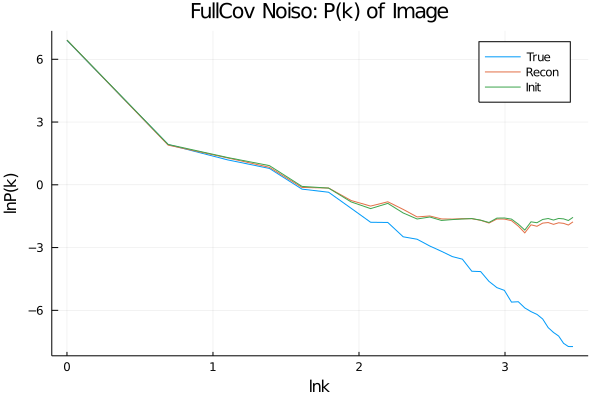

In [14]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

### Using the "Correct" Lambda

In [53]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LambdaVary/1000_tunedlam_fullcov_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS12=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True0.2792624951944618
115.48038402999249
Init269.1009695044303
0.0
Recon8.303597614720935
19.873282835880374


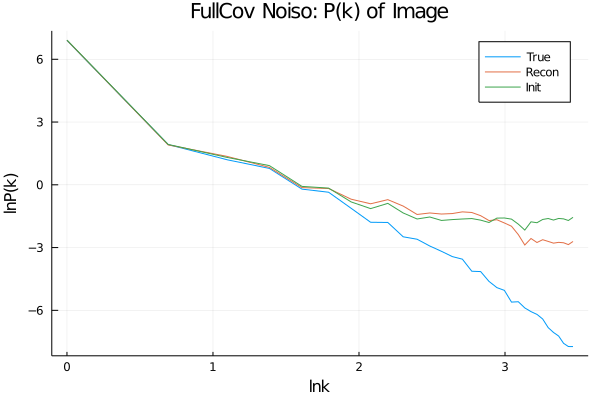

In [54]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

L1true>L1recon, but L1recon is a bit too large

In [55]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LambdaVary/1000_tunedlam_0-001_fullcov_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS12=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True0.2792624951944618
0.11548038402999249
Init269.1009695044303
0.0
Recon0.08742843539164658
0.07810493284902127


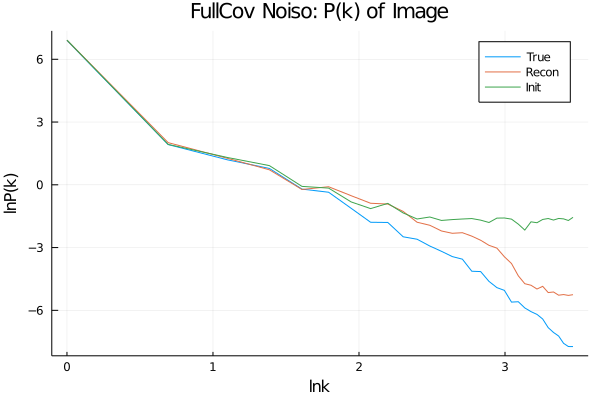

In [56]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

But now L1recon<L1true: we want L1true to be only slightly larger. The constraint is so relaxed it just makes an image that's more like the SFD targ mean than the true im.

In [57]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LambdaVary/1000_tunedlam_0-01_fullcov_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS12=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True0.2792624951944618
1.1548038402999252
Init269.1009695044303
0.0
Recon0.16792650399436093
0.5863955516203473


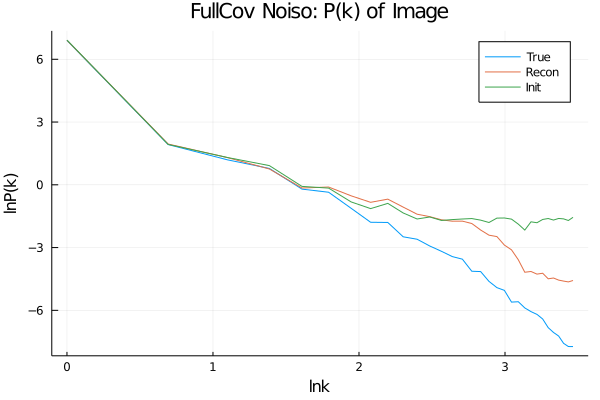

In [58]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

#### Diag Cov was way worse

### LogCoeff:
Does well on the power spectrum but BAD artefacts in some images. The recon Loss1 is closer to the target than the image itself and the image looks more dusty (when no artefacts) but it looks less like the actual true image. Increasing lambda to make Loss1recon<Loss1true doesn't help because you end up depressing the power spectrum.

In [23]:
#Log coeff, log im
Nx=64
dbnimg = readsfd_fromsrc("../../data/dust10000.fits", Nx, logbool=false)
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_0-01_full_triu"
gttarget = load(fname*".jld2")
dhc_args = gttarget["dhc_args"]
coeff_mask = gttarget["coeff_mask"]
fhash = gttarget["fhash"]
dbn1 = log.(get_dbn_coeffs(dbnimg[:, :, 1:5000], fhash, dhc_args, coeff_mask = coeff_mask))
dbn2 = log.(get_dbn_coeffs(dbnimg[:, :, 5001:end], fhash, dhc_args, coeff_mask= coeff_mask))


#Mean dia, cov
Ncovsamp = 5000
s_targ_mean = mean(dbn1, dims=1)[:, coeff_mask]
scov  = (dbn1 .- s_targ_mean)' * (dbn1 .- s_targ_mean) ./(Ncovsamp-1)
smean1, sdiag1, scov1 = s_targ_mean, diag(scov), scov
s_targ_mean = mean(dbn2, dims=1)[:, coeff_mask]
scov  = (dbn2 .- s_targ_mean)' * (dbn2 .- s_targ_mean) ./(Ncovsamp-1)
smean2, sdiag2, scov2 = s_targ_mean, diag(scov), scov


scov1inv = invert_covmat(scov1, 1e-8)
scov2inv = invert_covmat(scov2, 1e-8)

diff = dbn1 .- reshape(smean1, (1, 595))
chisq1 = sum((diff * scov1inv) .* diff, dims=2)


diff = dbn2 .- reshape(smean2, (1, 595))
chisq2 = sum((diff * scov2inv) .* diff, dims=2)

p = histogram(chisq1[:])
p = histogram(chisq2[:])
chisqsamp = rand(Distributions.Chisq(595), 5000)
histogram!(chisqsamp)


10000 slices


LoadError: BoundsError: attempt to access 1×595 Array{Float64,2} at index [1:1, Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

In [4]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_0-01_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS12=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True271.13355388014503
0.0008924165728318676
Init388.091139523465
0.0
Recon7.491648845931981
0.004156834933837604


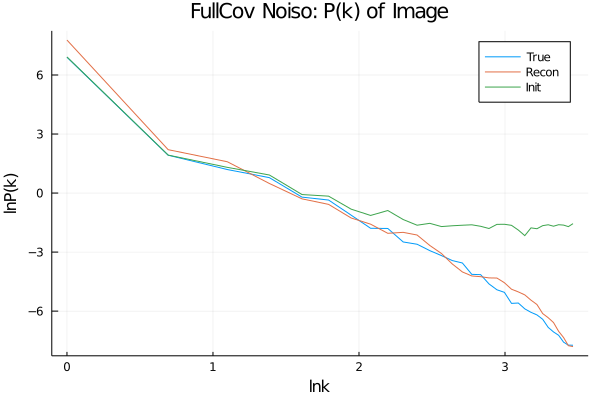

In [6]:
kbins=convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

In [24]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/100_0-01_full_triu(1)"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS12=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True303.96004607560695
0.000663804345057021
Init396.16639104998467
0.0
Recon7.349865540909647
0.001610416378724573


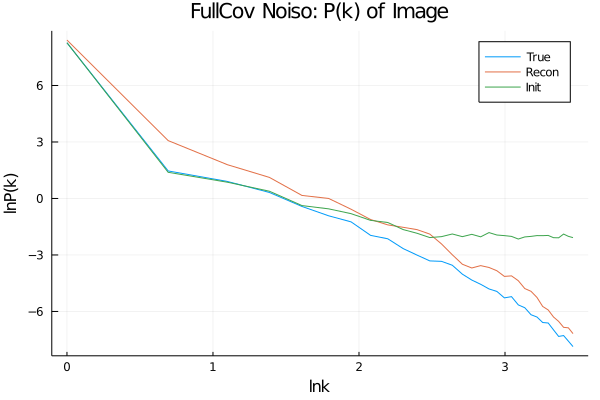

In [25]:
kbins=convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

In [27]:
svinv = diag(s_targ_invcov)
zscore_recon_true = svinv .* (s_recon - s_true)
zscore_true_targ = svinv .* (s_true - s_targ_mean)
zscore_recon_targ = svinv .* (s_recon - s_targ_mean)

595-element Array{Float64,1}:
  -202.33109338810814
  -267.45458216842525
  -186.47849985078906
  -321.90688798675126
  -218.3257930078061
  -171.19948737117699
 -1328.6882762495661
  -718.0462628786516
  -483.5158632635782
  -714.5341345187907
  -205.97073671099074
  -208.8329057759376
  -287.88947697217367
     ⋮
 -1043.6138866401134
 -1504.3768038895446
  -620.4916890782515
  -753.5006869457341
 -1284.8040797410667
 -3100.8421659804503
  -598.794313813813
  -698.9424879770891
 -1012.3680099934066
 -3057.79231577108
 -2928.2166573247337
  -186.07409613794994

In [13]:
zscore_true_targ

595-element Array{Float64,1}:
  -1876.5789722280647
  -1790.7046875799895
   -847.7402365484282
  -1671.6178690752981
   -743.3914249904652
   -453.9853874814325
  -4330.590226014356
  -1856.2920775664645
  -1114.20950023658
  -1548.6895861245914
  -1862.8718376496881
  -1179.3091867229105
  -1200.2802980061342
      ⋮
  -3832.3636721351204
  -8109.730097310466
  -4085.7648869398868
  -4722.381766623722
  -3948.4895747451765
 -10683.885238042933
  -4535.919492691775
  -4462.578797300025
  -3396.074724688409
  -8414.624859565749
 -15248.006551162964
  -1778.9533926553256

### Why are the zscores so high?

In [ ]:
datdir = "../../StandardizedExp/Nx64/Data_"
for f in [1, 10, 100, 1000, 10000]:
    s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
end

In [1]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_1-0_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS12=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


LoadError: UndefVarError: load not defined

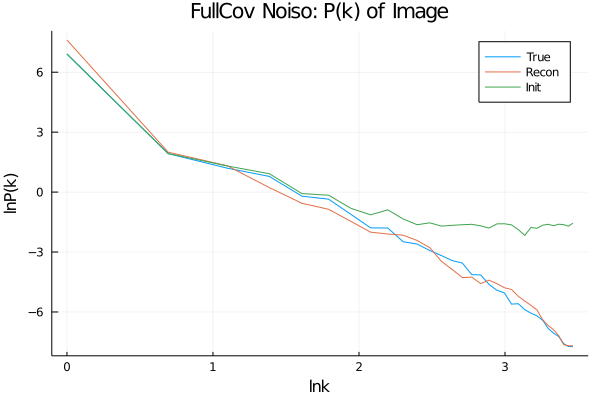

In [74]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

In [76]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_10_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS12=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True271.13355388014503
0.8924165728318676
Init388.091139523465
0.0
Recon7.196722678076889
1.1711584235470576


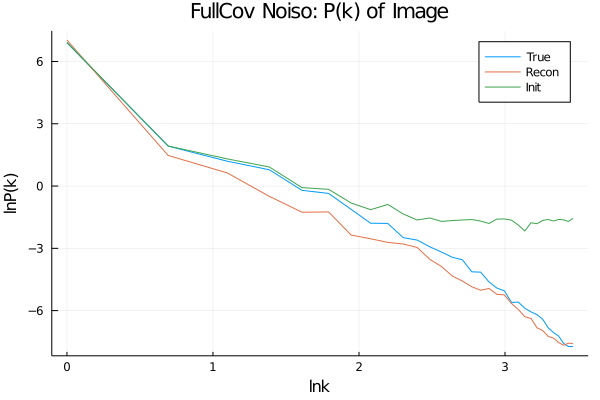

In [77]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

### Log Img's Coeffs

In [17]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/log_apd_noiso/1000_fullcov_triu"

gttarget = load(fname*".jld2")
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS12=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(log.(gttarget["true_img"]))
alinit = apodizer(log.(gttarget["init"]))
alrecon = apodizer(log.(gttarget["recon"]))

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(log.(gttarget["true_img"]), filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(log.(gttarget["init"]), filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(log.(gttarget["recon"]), filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
#446, 84503

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
#6e9, 0

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
#2.5e3, 6e4

ztrue_recon = (s_recon - s_true) .* diag(s_targ_invcov)
ztrue_target = (s_true - s_targ_mean) .* diag(s_targ_invcov)
zinit_target = (s_init - s_targ_mean) .* diag(s_targ_invcov)

scatter(log.(abs.(zinit_target)), log.(abs.(ztrue_recon)))
xlabel!("ln Abs Z score: Coeffs Target-Init")
ylabel!("ln Abs Z score: Coeffs Recon-True")

zscoremat = zeros(34, 34)
zscoremat[reshape(gttarget["coeff_mask"][3+34:end], (34, 34))] .= log.(abs.(ztrue_target))
heatmap(zscoremat, title="Im 1000: Ln Abs Z-Score b/w True & Target")


LoadError: UndefVarError: filter_hash not defined